There are 9885 images
The mean Pawpularity score is 38.049974709155286
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.599054723289758
There are 100 unique values of Pawpularity score
578 960


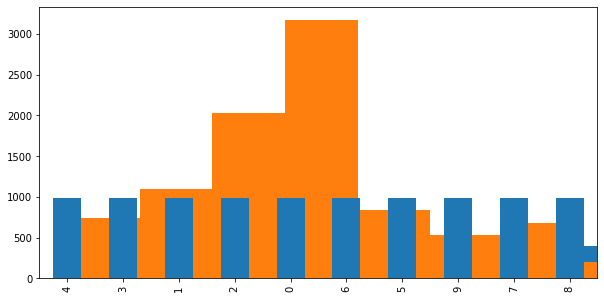

In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from timm.data.mixup import Mixup

from fastai.vision.all import *
#from fastai.callback.hook import *

set_seed(1, reproducible=True)
BATCH_SIZE = 32
NEED_TRAIN = False

clean_dataset_path = Path('../input/petfinder-pawpularity-score-clean/')
clean_dataset_path.ls()

dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

train_df = pd.read_csv(clean_dataset_path/'train.csv')
train_df.head()

train_df['path'] = train_df['Id'].map(lambda x:str(clean_dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

len_df = len(train_df)
print(f"There are {len_df} images")

train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

im

if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


seed=12
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

#Sturges' rule
num_bins = int(np.floor(1+np.log2(len(train_df))))
num_bins

train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

train_df[train_df['fold']==0].head()

train_df[train_df['fold']==0]['bins'].value_counts()

train_df[train_df['fold']==1]['bins'].value_counts()

def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    #mixup_fn = Mixup(**mixup_args)
    
#     dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                                valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    # It looks if seed of RandomSplitter is set, it reduce the score. So we don't set seed here
    splitter = RandomSplitter(0.2)
    # Change RandomSplitter to IndexSplitter
    splitter = IndexSplitter(splitter(range(len(train_df)))[1])
    dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('path'),
                get_y=ColReader('norm_score'),
                splitter=splitter,
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
               )
    
    paw_dls = dls.dataloaders(train_df_f, 
                          bs=BATCH_SIZE,
                          num_workers=8,
                          seed=seed)
    
    return paw_dls, splitter


def get_learner(fold_num):
    data, splitter = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse, cbs=[MixUp(0.2)]).to_fp16()
    
    return learn, splitter

test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

if len(test_df) != 8:
    NEED_TRAIN = True

test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

import gc

from sklearn.metrics import mean_squared_error

if NEED_TRAIN:
    all_preds = []
    train_df['pred'] = -1

    for i in range(N_FOLDS):

        print(f'Fold {i} results')

        learn, splitter = get_learner(fold_num=i)
        
#         mixup_args = {
#             'mixup_alpha': 1.,
#             'cutmix_alpha': 0.,
#             'cutmix_minmax': None,
#             'prob': 1.0,
#             'switch_prob': 0.,
#             'mode': 'batch',
#             'label_smoothing': 0,
#             'num_classes': 100}
        
#         mixup_fn = Mixup(**mixup_args)

        learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 

        learn.recorder.plot_loss()
        
        #over fitting
#         learn.unfreeze()
        
#         learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))

        #learn = learn.to_fp32()

        learn.export(f'model_fold_{i}.pkl')
        #learn.save(f'model_fold_{i}.pkl')

#         dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                    valid_pct=0.2, #80-20 train-validation random split
#                                    seed=999, #seed
#                                    fn_col='path', #filename/path is in the second column of the DataFrame
#                                    label_col='norm_score', #label is in the first column of the DataFrame
#                                    y_block=RegressionBlock, #The type of target
#                                    bs=BATCH_SIZE, #pass in batch size
#                                    num_workers=8,
#                                    item_tfms=Resize(224), #item_tfms=RandomResizedCrop(224, min_scale=0.3) #pass in item_tfms
#                                    batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 

        dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                    get_x=ColReader('path'),
                    get_y=ColReader('norm_score'),
                    splitter=RandomSplitter(0.2),
                    item_tfms=Resize(224), #pass in item_tfms
                    batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
                   )

        paw_dls = dls.dataloaders(train_df, 
                              bs=BATCH_SIZE,
                              num_workers=8,
                          seed=seed)
        
        test_dl = paw_dls.test_dl(test_df)

        preds, _ = learn.tta(dl=test_dl, n=5, beta=0)

        all_preds.append(preds)
        
        val_idx = splitter(range(len(train_df)))[1]
        val_df = train_df.loc[val_idx]
        val_pred, _ = learn.tta(dl=paw_dls.test_dl(val_df), n=5, beta=0)
        print(val_df['Pawpularity'][:5], val_pred[:5])
        score = mean_squared_error(val_df['Pawpularity'], val_pred*100, squared=False)
        print(f'Fold {i} | Score: {score}')
        # Save prediction of validation as pred
        train_df.loc[val_idx, 'pred'] = val_pred*100

        del learn

        torch.cuda.empty_cache()

        gc.collect()
        
        #Only run one fold for public train as we don't have so many GPU time
        if len(test_df) == 8:
            break
    if len(test_df) == 8:
        cv_score = mean_squared_error(train_df.loc[train_df['pred']!=-1, 'Pawpularity'], 
                                      train_df.loc[train_df['pred']!=-1, 'pred'], squared=False)
        print(f'CV Score: {cv_score}')

if NEED_TRAIN:
    all_preds, np.mean(np.stack(all_preds*100))

sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
if NEED_TRAIN:
    preds = np.mean(np.stack(all_preds), axis=0)
    sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

if not NEED_TRAIN:
    pd.read_csv('submission.csv').head()